# Model 3 : Neural Network

##### Imports

In [100]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from sklearn.model_selection import train_test_split

#### Bag of Words Class

In [101]:

class BagOfWords:
    def __init__(self):
        self.vocabulary = {}
    
    def fit(self, documents):
        unique_words = set()
        for doc in documents:                   
            unique_words.update(doc.split())    

        self.vocabulary = {word: idx for idx, word in enumerate(unique_words)}
    
    def vectorize(self, sentence):  # convert sentence into vector
        
        vector = np.zeros(len(self.vocabulary), dtype=int)

        for word in sentence.split():
            if word in self.vocabulary:
                vector[self.vocabulary[word]] += 1
        return vector
    
    def transform(self, documents):
        return np.array([self.vectorize(doc) for doc in documents])




### Reading article data and Train-Test-Eval Split
#### 70-15-15 split

In [111]:

df_cleaned = pd.read_csv(r"cleaned.csv")

df_inputs = df_cleaned.drop(columns=["Gold Labels"])
df_outputs = df_cleaned["Gold Labels"]
# Split the dataset into training and test sets with test_size=0.3
# X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, test_size=0.3, random_state=1)


X_train, X_temp, y_train, y_temp = train_test_split(df_inputs, df_outputs, test_size=0.3, random_state=15, stratify=df_outputs)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=22, stratify=y_temp)




print(f"Training set   : X_train.shape: {X_train.shape}  |  y_train.shape: {y_train.shape} ")
print(f"Validation set : X_val.shape: {X_val.shape}    |  y_val.shape {y_val.shape}")
print(f"Test set       : X_test.shape {X_test.shape}    |  y_test.shape {y_test.shape}   ")

# print(X_train.shape)
# print(X_test.shape)
X_train.head()

Training set   : X_train.shape: (784, 4)  |  y_train.shape: (784,) 
Validation set : X_val.shape: (168, 4)    |  y_val.shape (168,)
Test set       : X_test.shape (169, 4)    |  y_test.shape (169,)   


,Article IDs,Titles,Links,Contents
981,986,شکیب الحسن نئی مشکل میں! بالنگ ایکشن مشکوک قرار,https://www.express.pk/story/2731608/shakib-al...,انگلش کاؤنٹی چیمپئین شپ دوران سابق بنگلادیشی ک...
65,65,مالی سال کے ابتدائی 4 ماہ میں پاکستان کو 11.84...,https://urdu.geo.tv/latest/386082-,کراچی اسٹیٹ بینک نے ترسیلات زر تفصیلات جاری کر...
742,742,جارجیا: 5 پولنگ بوتھز پر بم کی غیر مصدقہ دھمکی...,https://jang.com.pk/news/1408361,امریکی ریاست جارجیا میں پولنگ بوتھز بم غیر مصد...
1112,1134,امریکا میں صدارتی الیکشن نومبر کے پہلے منگل کو...,https://www.express.pk/story/2731517/uselectio...,امریکا میں صدارتی الیکشن اپنے مقررہ سال میں نو...
349,349,سہانا خان نے شاہ رخ کی سالگرہ پر خصوصی پیغام م...,https://jang.com.pk/news/1407193,بالی ووڈ بادشاہ شاہ رخ خان کو اپنی ویں سالگرہ ...


##### Fitting Bag of words

In [112]:
bag = BagOfWords()
bag.fit(X_train["Contents"])
print(len(bag.vocabulary))
print(bag.vocabulary)

11290
{'زمین': 0, 'ہوگئے،': 1, 'جدی': 2, 'جیمنائی': 3, 'تحریک': 4, 'اینمل': 5, 'مشورے': 6, 'انتخابی': 7, 'پچھتائی': 8, 'مزین': 9, 'آمریت': 10, 'ہورہا،': 11, 'دودھ،': 12, 'ندیم': 13, 'پیپلز': 14, 'سورما': 15, 'میلے': 16, 'مارچ': 17, 'پھیلاؤ': 18, 'کپیسٹی': 19, 'نیدرلینڈز': 20, 'شیخوپورہ،': 21, 'نیچےآئی۔': 22, 'ہارڈی،': 23, 'حس': 24, 'الائنس': 25, 'چوڑا': 26, 'انسٹیٹیوٹ': 27, 'طیارہ': 28, 'دہلی': 29, 'رانا،': 30, 'لڑکھڑاتے': 31, 'فوڈز،': 32, 'ہوتا،': 33, 'علیہ': 34, 'جیت': 35, 'انصاری،': 36, 'تمہارے،': 37, 'آٹھواں': 38, 'ظہار': 39, 'کنفیوژن': 40, 'زنک': 41, 'کرناپڑا،': 42, 'تارکین': 43, 'سنگاپور': 44, 'کھائی': 45, 'تاجولائی': 46, 'سلطان،': 47, 'حفی': 48, 'لینگویج': 49, 'رُونمائی': 50, 'استغاثہ': 51, 'حسین،': 52, 'وفاداروں': 53, 'قانونِ': 54, 'آم': 55, 'مشکور': 56, 'قطعی': 57, 'حادثات': 58, 'فیاض': 59, 'محققین': 60, 'امدد': 61, 'رہنا': 62, 'کرلیے۔': 63, 'آیا،': 64, 'کیشو': 65, 'اکاؤنٹ': 66, 'ترک': 67, 'زید': 68, 'سیارے': 69, 'مدیحہ': 70, 'اٹیچ': 71, 'سانگھڑ': 72, 'ذوہری': 73, 'رکھا۔': 7

#### Vectorizing using bag of words 

In [113]:

X_train_vectors = bag.transform(X_train['Contents'])
X_val_vectors = bag.transform(X_val['Contents'])
X_test_vectors = bag.transform(X_test['Contents'])

print(X_train["Contents"].shape)
print(X_val["Contents"].shape)
print(X_test["Contents"].shape)

print("----"*3)
print(X_train_vectors.shape)
print(X_val_vectors.shape)
print(X_test_vectors.shape)
print("----"*3, '\n')

print(X_train_vectors[0])


(784,)
(168,)
(169,)
------------
(784, 11290)
(168, 11290)
(169, 11290)
------------ 

[0 0 0 ... 0 0 0]


## Neural Network Model

In [ ]:

# MultiClassClassifier class for 5 classes
class MultiClassClassifier(nn.Module):
    def __init__(self, input_dims, num_classes=5):
        super().__init__()
        self.input_dims = input_dims
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(input_dims, 128),  
            nn.Sigmoid(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

# Training Loop 
1. **fit_one_epoch**: Performs one epoch of training 
  
2. **evaluate**: Evaluates the model on the validation set
 
3. **fit**: Run all epochs, recording training and validation accuracies and losses 

In [115]:
def fit_one_epoch(model, X, y, optimizer, loss_fn, batch_size):
    '''
    Perform one epoch of training for multi-class classification
    '''
    model.train()
    total_loss = 0
    correct = 0

    # Process data in batches
    num_samples = len(X)
    for i in range(0, num_samples, batch_size):
        x_batch = X[i:i+batch_size]  
        y_batch = y[i:i+batch_size]  

        y_pred = model(x_batch) 

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        # Calculate correct predictions
        predicted_classes = torch.argmax(y_pred, dim=1)  
        correct += (predicted_classes == y_batch).sum().item()

    accuracy = correct / num_samples

    return total_loss / num_samples, accuracy

@torch.no_grad()
def evaluate(model, X, y, loss_fn, batch_size = 128):
    '''
    Perform one epoch of evaluation for multi-class classification
    '''
    model.eval()
    total_loss = 0
    correct = 0

    num_samples = len(X)
    for i in range(0, num_samples, batch_size):
        x_batch = X[i:i+batch_size]  
        y_batch = y[i:i+batch_size]  

        y_pred = model(x_batch)  

        # Calculate loss
        loss = loss_fn(y_pred, y_batch)
        total_loss += loss.item()

        predicted_classes = torch.argmax(y_pred, dim=1) 
        correct += (predicted_classes == y_batch).sum().item()

    accuracy = correct / num_samples

    return total_loss / num_samples, accuracy

def fit(
    model, X_train, y_train, X_val, y_val,
    optimizer, loss_fn, epochs, batch_size=128):
    '''
    Perform the entire training process for multi-class classification
    '''
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn, batch_size)
        val_loss, val_acc = evaluate(model, X_val, y_val, loss_fn, batch_size)
        
        # storing all the losses and accuracies
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print("--------------------------------------------------------------------")
        print(f"                     Epoch {epoch+1}/{epochs}:")
        print(f"             Train Loss: {train_loss:.4f}, Train Accuracy: {(train_acc*100):.2f} %")
        print(f"              Val Loss: {val_loss:.4f},  Val Accuracy: {(val_acc*100):.2f} %")

    print("--------------------------------------------------------------------")

    return train_losses, train_accuracies, val_losses, val_accuracies


### Neural Network Declaration
-  Loss function, learning rate and optimizer
- Converting Inputs to tensors

In [116]:

input_dims = X_train_vectors.shape[1]  # Number of features in Bag of Words

print(input_dims)
num_classes = 5
model = MultiClassClassifier(input_dims=input_dims, num_classes=num_classes)

# Loss function, learning rate and optimizer
loss_fn = nn.CrossEntropyLoss()  
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Converting to tensors
X_trainT = torch.tensor(X_train_vectors, dtype=torch.float32)
X_valT = torch.tensor(X_val_vectors, dtype=torch.float32)

# Create a mapping from class names to numeric indices
class_mapping = {label: idx for idx, label in enumerate(y_train.unique())}
y_train_numeric = y_train.map(class_mapping)
y_val_numeric = y_val.map(class_mapping)
# Convert the mapped labels to PyTorch tensors
y_trainT = torch.tensor(y_train_numeric.values, dtype=torch.long)  
y_valT = torch.tensor(y_val_numeric.values, dtype=torch.long)

print("Class Mapping:", class_mapping)



11290
Class Mapping: {'sports': 0, 'business': 1, 'world': 2, 'entertainment': 3, 'science-technology': 4}


## Running the training loop

In [117]:

epochs = 30

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model, X_trainT, y_trainT, X_valT, y_valT, optimizer, loss_fn, epochs
)


--------------------------------------------------------------------
                     Epoch 1/30:
             Train Loss: 0.0143, Train Accuracy: 34.69 %
              Val Loss: 0.0187,  Val Accuracy: 56.55 %
--------------------------------------------------------------------
                     Epoch 2/30:
             Train Loss: 0.0138, Train Accuracy: 71.81 %
              Val Loss: 0.0181,  Val Accuracy: 76.79 %
--------------------------------------------------------------------
                     Epoch 3/30:
             Train Loss: 0.0132, Train Accuracy: 87.50 %
              Val Loss: 0.0173,  Val Accuracy: 91.67 %
--------------------------------------------------------------------
                     Epoch 4/30:
             Train Loss: 0.0125, Train Accuracy: 96.30 %
              Val Loss: 0.0164,  Val Accuracy: 96.43 %
--------------------------------------------------------------------
                     Epoch 5/30:
             Train Loss: 0.0116, Train Acc

### Plotting Loss and Accuracy Curves 

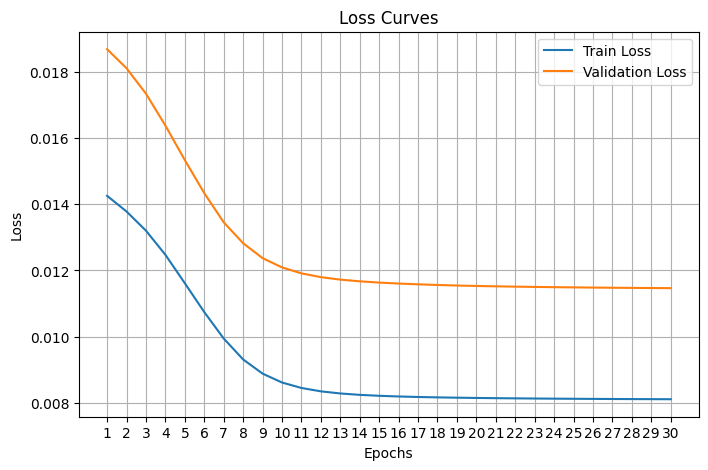

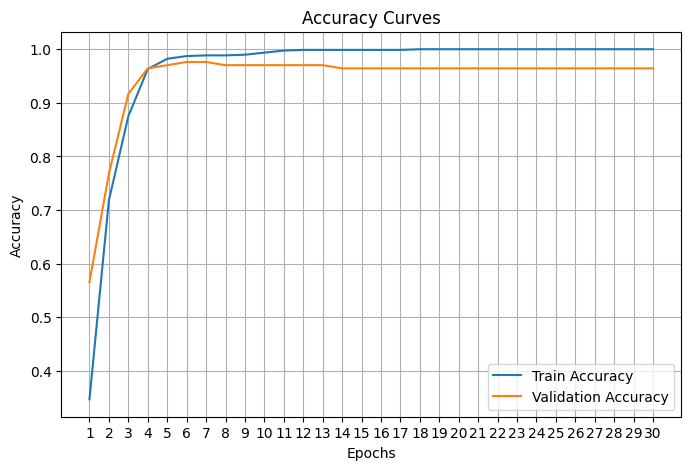

In [118]:

# Plot Loss Curves
plt.figure(figsize=(8, 5))
# plt.subplot(2,1,1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.xticks(range(1, epochs + 1)) 

plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(8, 5))
# plt.subplot(2,1,2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.xticks(range(1, epochs + 1)) 
plt.show()


## Running on Test Set

In [119]:


X_testT = torch.tensor(X_test_vectors, dtype=torch.float32)


y_test_numeric = y_test.map(class_mapping)

y_testT = torch.tensor(y_test_numeric.values, dtype=torch.long)  # Numeric class indices



test_loss, test_accuracy = evaluate(model, X_testT, y_testT, loss_fn)

# test results
print(f"Test Loss: {test_loss:.4f}  \nTest Accuracy: {(100*test_accuracy):.2f} %")


Test Loss: 0.0114  
Test Accuracy: 97.04 %


### Classification Report

In [120]:
from sklearn.metrics import classification_report

# Assuming y_train.unique() gives the unique class labels in the dataset
class_mapping = {label: idx for idx, label in enumerate(y_train.unique())}
class_names = list(class_mapping.keys())  

X_testT = X_testT.view(X_testT.size(0), -1)
print(X_testT.shape)
print(y_testT.shape)
print("----------------------------------")

model.eval()
with torch.no_grad():
    y_test_pred = model(X_testT)  
    y_test_pred_labels = torch.argmax(y_test_pred, dim=1).numpy()  

print("Classification Report:")
print(classification_report(y_testT.numpy(), y_test_pred_labels, target_names=class_names))


torch.Size([169, 11290])
torch.Size([169])
----------------------------------
Classification Report:
                    precision    recall  f1-score   support

            sports       0.94      1.00      0.97        34
          business       0.97      0.94      0.95        33
             world       0.97      0.97      0.97        35
     entertainment       0.97      1.00      0.99        35
science-technology       1.00      0.94      0.97        32

          accuracy                           0.97       169
         macro avg       0.97      0.97      0.97       169
      weighted avg       0.97      0.97      0.97       169



### Confusion Matrix

<Figure size 2000x2000 with 0 Axes>

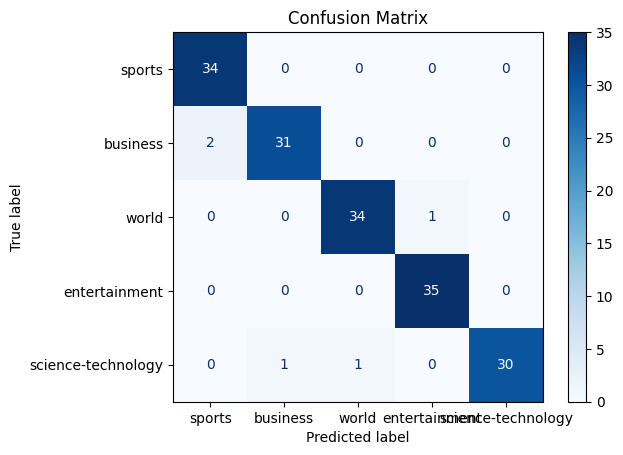

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_testT.numpy(), y_test_pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(20,20))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
